In [1]:
import cv2
import numpy as np
from PIL import Image
from skimage.morphology import skeletonize, thin

import matplotlib.pyplot as plt

from extract_network import find_color, extract_network, render_skeleton, render_network

In [2]:
rgb = (255, 255, 255)
png_file = 'samples/gt/1_gray.png'
im = Image.open(png_file)

In [3]:
px = find_color(im, rgb).T
g = extract_network(px, 16)
print(f'Extracted street network:')
print(f'  - {len(g.nodes())} nodes')
print(f'  - {len(g.edges())} edges')

# skel = skeletonize(px)
skel = thin(px)

skel_path = png_file.replace('.png', '.skel.png')
img_skeleton = render_skeleton(im, skel, (255, 0, 0))

out_path = png_file.replace('.png', '.grid.png')
img_network = render_network(im, g, (0, 255, 0))



Skeleton px=6322
Adding 13/24 dense nodes to existing 307 nodes.
Merged (295, 359) and (296, 361), d=2
Merged (295, 360) and (297, 360), d=2
Merged (297, 362) and (298, 361), d=1
Merged (309, 286) and (311, 286), d=2
Merged (310, 286) and (311, 288), d=2
Merged (319, 418) and (321, 419), d=2
Merged (325, 295) and (327, 296), d=2
Merged (326, 295) and (327, 297), d=2
Merged (327, 407) and (328, 405), d=2
Merged (329, 403) and (330, 404), d=1
Merged (327, 406) and (329, 406), d=2
Merged (328, 405) and (329, 403), d=2
Merged (330, 297) and (330, 298), d=1
Merged (332, 299) and (333, 298), d=1
Merged (335, 267) and (336, 267), d=1
Merged (336, 383) and (336, 385), d=2
Merged (335, 267) and (337, 269), d=2
Merged (336, 268) and (338, 268), d=2
Merged (338, 270) and (339, 269), d=1
Merged (345, 362) and (345, 364), d=2
Merged (348, 279) and (348, 281), d=2
Merged (349, 222) and (350, 224), d=2
Merged (349, 223) and (351, 223), d=2
Merged (351, 225) and (352, 224), d=1
Merged (351, 225) and (

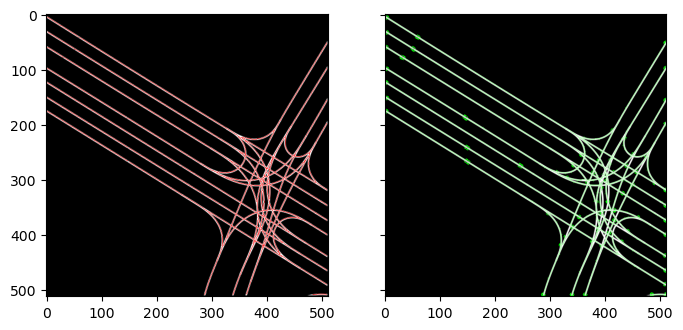

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)
axes[0].imshow(img_skeleton)
axes[1].imshow(img_network)
plt.show()

# img_network.show()
# print(f'Wrote {out_path}')

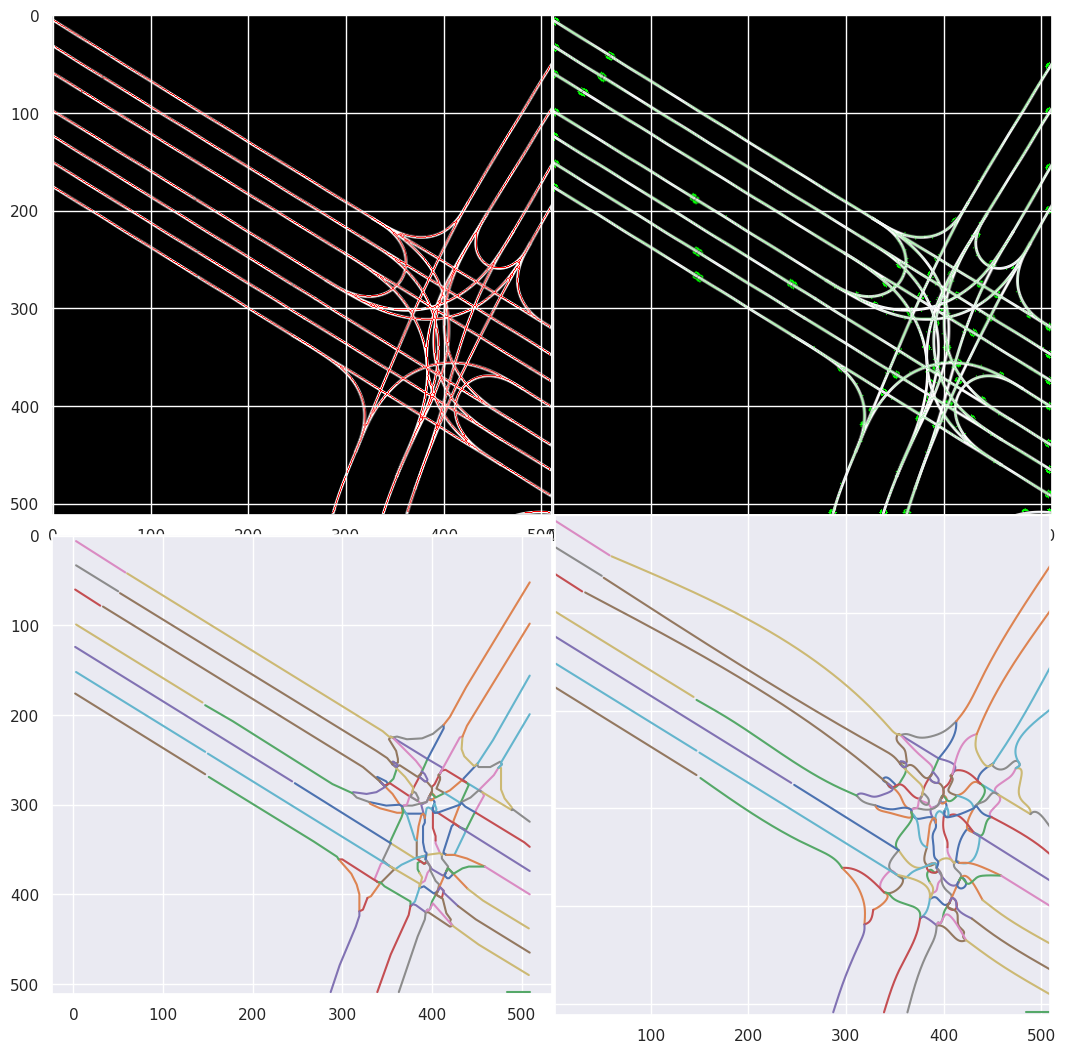

In [30]:
import networkx as nx
# import numpy.polynomial.polynomial as P
# from scipy.interpolate import CubicSpline
from cubic_spline import CubicSpline2D

def network_to_polylines(g: nx.Graph):
    for i, (n1, n2, k) in enumerate(g.edges(keys=True)):
        edge = g[n1][n2][k]
        path = edge['path']
        coords = np.array(path.coords)
        yield coords

polylines = network_to_polylines(g)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axes = axes.ravel()

# def generate_frenet_frame(centerline_pts: np.ndarray):
def generate_frenet_frame(xs: np.ndarray, ys: np.ndarray):
    cubic_spline = CubicSpline2D(xs, ys)
    s = np.arange(0, cubic_spline.s[-1], 0.1)
    # s = np.linspace(0, cubic_spline.s[-1], xs.shape[0])
    ref_xy = [cubic_spline.calc_position(i_s) for i_s in s]
    ref_yaw = [cubic_spline.calc_yaw(i_s) for i_s in s]
    ref_rk = [cubic_spline.calc_curvature(i_s) for i_s in s]
    return cubic_spline, np.column_stack((ref_xy, ref_yaw, ref_rk))

for polyline in polylines:
    xs = polyline[:, 0]
    ys = polyline[:, 1]
    axes[2].plot(xs, ys)

    # polyline = np.unique(polyline, return_index=False, axis=0)

    # sort_order = xs.argsort()
    # xs_sorted = xs[sort_order]
    # ys_sorted = ys[sort_order]
    # print(xs_sorted)
    # print(ys_sorted)
    # axes[3].plot(xs_sorted, ys_sorted)

    # xs_unique, x_ids = np.unique(xs_sorted, return_index=True, axis=0)
    # ys_unique = ys_sorted[x_ids]
    # axes[3].plot(xs_unique, ys_unique)

    # cs = CubicSpline(xs_unique, ys_unique, bc_type='natural', extrapolate=True)
    # cubic_spline = CubicSpline2D(xs_sorted, ys_sorted)

    # sort_order = xs.argsort()
    # xs_sorted = xs[sort_order]
    # ys_sorted = ys[sort_order]
    # print(xs_sorted)
    # print(ys_sorted)
    # axes[3].plot(xs_sorted, ys_sorted)

    cubic_spline, ref_curve = generate_frenet_frame(xs, ys)
    axes[3].plot(ref_curve[:, 0], ref_curve[:, 1])

axes[0].imshow(img_skeleton)
axes[1].imshow(img_network)
axes[2].set_aspect('equal')
axes[2].invert_yaxis()
axes[3].set_aspect('equal')
axes[3].invert_yaxis()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.show()

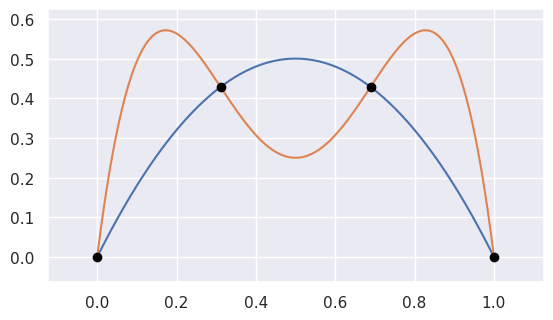

In [7]:
import bezier
import seaborn
import numpy as np

nodes1 = np.asfortranarray([
    [0.0, 0.5, 1.0],
    [0.0, 1.0, 0.0],
])
curve1 = bezier.Curve(nodes1, degree=2)

nodes2 = np.asfortranarray([
    [0.0, 0.25,  0.5, 0.75, 1.0],
    [0.0, 2.0 , -2.0, 2.0 , 0.0],
])
curve2 = bezier.Curve.from_nodes(nodes2)
intersections = curve1.intersect(curve2)

s_vals = np.asfortranarray(intersections[0, :])
points = curve1.evaluate_multi(s_vals)

seaborn.set()
ax = curve1.plot(num_pts=256)
_ = curve2.plot(num_pts=256, ax=ax)
lines = ax.plot(
    points[0, :], points[1, :],
    marker="o", linestyle="None", color="black")
_ = ax.axis("scaled")
_ = ax.set_xlim(-0.125, 1.125)
_ = ax.set_ylim(-0.0625, 0.625)